## Intro

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RERUN = False

The main purpose of this doc, is trying to determine the right number of topics for our corpus (currently handling only nonbib, hebrew texts).
Ive sucseeded to lemmatize the text with the [dictabert-lex](https://huggingface.co/dicta-il/dictabert-lex) model which attempts to match up each word with the correct lexeme from within the BERT vocabulary.
This doc structure is as follows:
1. What are the problems in the current research for dealing with the problem of choosing the right number of topics.
2. Some additional pre-processing to the corpus.
3. Choosing number of topics:
    1. Running multiple LDA models with a different number of optional topics and plot varoius metrics.
    2. Running hierarchical dirichlet process for inferring number of topics.
    3. Hyper parameter tuning for best number of topics.
4. Short analysis of the topics after selecting (probably) the right number of topics. Chosen number of topics = 18-19 (regular text 18, lemmatized 19)



## Data

In [2]:
#Data Pre processing in ETL notebook
df_by_book = pd.read_csv('data/full_data_nonbib_01_05_24.csv')

## Topic modeling

### Choosing the right number of topics

When performing topic modeling with LDA, one of the parameters that we need to provide is the number of topics we wish to get as the result.
This problem is a bit challenging because of the following reasons:
1. Subjective Interpretations: The determination of what constitutes a coherent topic is subjective and varies between users. This variability makes it difficult to establish a universally optimal number of topics that satisfy all interpretations and use cases.
Reference: Chang, J., Boyd-Graber, J., Gerrish, S., Wang, C., & Blei, D. M. (2009). [Reading Tea Leaves: How Humans Interpret Topic Models](https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf)

2. Corpus Characteristics: The diversity and dimensions of the dataset—such as document length, the breadth of vocabulary, and the granularity of content—play a critical role in influencing the appropriate number of topics. Different corpora may naturally support different numbers of distinct themes.
Reference: Greene, D., O'Callaghan, D., & Cunningham, P. (2014). [How Many Topics? Stability Analysis for Topic Models](https://arxiv.org/pdf/1404.4606)

3. Absence of Ground Truth: In unsupervised learning, like topic modeling, there is no clear benchmark or ground truth for validating the chosen number of topics. This absence makes it challenging to objectively evaluate the accuracy and relevance of the model's output.
Reference: [On finding the natural number of topics with latent dirichlet allocation: Some observations](https://link.springer.com/chapter/10.1007/978-3-642-13657-3_43)


4. Sensitivity to Model Specifications: The chosen number of topics can be sensitive to slight variations in model parameters or the data preprocessing steps. This sensitivity often results in different models suggesting different numbers of topics for the same dataset, complicating the selection process.
Reference: Lau, J. H., Newman, D., & Baldwin, T. (2014). [Machine reading tea leaves: Automatically evaluating topic coherence and topic model quality](https://aclanthology.org/E14-1056/)


As for today, the main metrics for choosing the number of topics are:

1. Coherence Measures: Coherence scores, such as C_V, UMass, C_UCI, and C_NPMI, are widely used because they offer a quantitative way to assess the semantic coherence of the topics produced by the model. These measures evaluate how meaningfully the top words in each topic relate to each other, with higher scores generally indicating better topics. (Appendix below)
Reference: Röder, M., Both, A., & Hinneburg, A. (2015). [Exploring the space of topic coherence measures](https://dl.acm.org/doi/10.1145/2684822.2685324)

2. Perplexity: Perplexity is a statistical measure of how well a probability model predicts a sample. In topic modeling, lower perplexity is typically associated with a model that can better predict unseen documents, although it does not necessarily correlate with human interpretability of the topics.
Reference: Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). [Latent dirichlet allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
$$
\text{perplexity}({D_{test}}) = \exp\left\{-\frac{\sum_{d=1}^{M} \log p(w_d)}{\sum_{d=1}^{M} N_d}\right\}
$$


3. Stability Analysis (didn't implement it in this doc): Stability analysis involves measuring how consistent the topics are across different runs of the model, with varying parameters or subsamples of the data. Consistent topics across multiple tests can indicate that the model has found a meaningful structure in the data.
Reference: Mimno, D., Wallach, H. M., Talley, E., Leenders, M., & McCallum, A. (2011). [Optimizing semantic coherence in topic models](https://aclanthology.org/D11-1024/)

4. Human Judgment: Ultimately, qualitative evaluation by subject matter experts is often used in conjunction with quantitative methods. Experts assess the meaningfulness and utility of the topics within the context of specific research or business objectives.
Reference: Chang, J., Boyd-Graber, J., Gerrish, S., Wang, C., & Blei, D. M. (2009). [Reading Tea Leaves: How Humans Interpret Topic Models](https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf)


* Another interesting way is to use [Hierarchical Dirichlet Processes](https://people.eecs.berkeley.edu/~jordan/papers/hdp.pdf) which can infer what is the optimal number of topics (the problem is selecting the right parameters). Implemented at the end of this doc.
* There are also a few papers that tried to use some new metrics (combining a few metrics together) like in [Selection of the Optimal Number of Topics for LDA Topic Model—Taking Patent Policy Analysis as an Example](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8534395/), [A heuristic approach to determine an appropriate number of topics in topic modeling](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-16-S13-S8) 



#### Number of topics with hyper-parameter tuning (trying 2-200 topics)

In [3]:
import gensim
from gensim import corpora
import tomotopy as tp
import pandas as pd
from scipy.spatial import distance
from datetime import datetime


# Functions related to word frequency analysis
def get_top_n_words(texts, n):
    word_counts = Counter([word for text in texts for word in text])
    return [word[0] for word in word_counts.most_common(n)]


def get_bottom_n_words(texts, n):
    word_counts = Counter([word for text in texts for word in text])
    return [word[0] for word in word_counts.most_common()[:-n - 1:-1]]


def remove_words_from_text(texts, words_to_remove):
    new_texts = []
    for text in texts:
        new_texts.append([word for word in text if word not in words_to_remove])
    return new_texts


def bigram_per_prcosessing(texts, min_count_bigram, threshold_bigram):
    bigram = gensim.models.Phrases(texts, min_count=min_count_bigram, threshold=threshold_bigram)
    texts = [bigram[text] for text in texts]
    return texts


def common_non_common_words_removal(texts, top_words_removal, bottom_words_removal):
    most_common_words = get_top_n_words(texts, top_words_removal)
    texts = remove_words_from_text(texts, most_common_words)
    least_common_words = get_bottom_n_words(texts, bottom_words_removal)
    texts = remove_words_from_text(texts, least_common_words)

    print(f"Removed {most_common_words}, {least_common_words} from text")
    return texts


def generate_components(column, random_state, min_count_bigram, threshold_bigram, top_words_removal,
                        bottom_words_removal, words_removal=True, bigram_process=True):
    # train_texts, test_texts = train_test_split(
    #     [[word for word in str(doc).split(" ")] for doc in df_by_book[column]],
    #     test_size=test_size, random_state=random_state
    # )
    texts = [[word for word in str(doc).split(" ")] for doc in df_by_book[column]]
    if bigram_process:
        texts = bigram_per_prcosessing(texts, min_count_bigram, threshold_bigram)
    if words_removal:
        texts = common_non_common_words_removal(texts, top_words_removal, bottom_words_removal)
    # texts = pre_processing_bigram_common_words(texts, min_count_bigram, threshold_bigram, top_words_removal, bottom_words_removal)

    # Building corpora and dictionaries for train and test sets
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]

    return (texts, id2word, corpus)


def compute_perplexity(lda_model):
    """ Computes the perplexity of the LDA model """
    return lda_model.perplexity


def js_divergence(model):
    """ Computes the Jensen-Shannon divergence between topic distributions """
    topic_probs = [model.get_topic_word_dist(k) for k in range(model.k)]
    avg_probs = np.mean(topic_probs, axis=0)
    js_divs = []
    for probs in topic_probs:
        js_div = distance.jensenshannon(probs, avg_probs, base=2)
        js_divs.append(js_div)
    return np.mean(js_divs)


def train_multiple_lda_tomotopy(topic_nums: range, corpus):
    results = []
    models = []
    for k in topic_nums:
        tmp_iter = {}
        model = tp.LDAModel(k=k, alpha=1.0 / k, eta=1.0 / k, min_cf=0, corpus=corpus, seed=42)
        model.train(200)  # number of iterations, adjust as necessary
        models.append(model)
        perplexity = compute_perplexity(model)
        js_div = js_divergence(model)
        for coherence_met in ['u_mass', 'c_v', 'c_uci', 'c_npmi']:
            ch = tp.coherence.Coherence(model, coherence=coherence_met)
            tmp_iter.update({f"Coherence_{coherence_met}": ch.get_score()})
        ll = model.ll_per_word
        tmp_iter.update({"num_topics": k, "perplexity": perplexity, "js_div": js_div, "ll": ll})
        print(f"{datetime.now()} - {tmp_iter}")
        results.append(tmp_iter)
    results = pd.DataFrame(results)
    return results


The main packages for doing topic modeling in python today are [Gensim](https://radimrehurek.com/gensim/), [scikit-learn](https://scikit-learn.org/) and [tomotopy](https://bab2min.github.io/tomotopy/v0.12.6/en/).
Tomotopy is the fastest (written in C), most maintainable for today, and when i compared the results, the tomotopy seems much better.

Here im removing very common words (the 8th most common words) and the 10 least common words.
Im also concatenate the most common bi-words (2 words that occur one another like בית המקדש will converted to בית_המקדש).

In [4]:

texts_lem, id2word_lem, corpus_lem = generate_components("lemmatized_text", 42, 1, 4, 8, 10, words_removal=True,
                                                         bigram_process=True)
texts, id2word, corpus = generate_components("processed_text", 42, 1, 4, 8, 10, words_removal=True, bigram_process=True)
corpus_tp = tp.utils.Corpus()
for text in texts:
    corpus_tp.add_doc(words=text)
corpus_tp_lem = tp.utils.Corpus()
for text in texts_lem:
    corpus_tp_lem.add_doc(words=text)



Removed ['כול', 'לוא', 'יום', 'איש', 'עם', 'בן', 'ישראל', 'ארץ'], ['למיום', 'לאר', 'חירם', 'אח_רע', 'שחרע', 'הכנעה', 'ונקח', 'שם_שת', 'וזנוח', 'היקח'] from text
Removed ['כול', 'לוא', 'כיא', 'די', 'ישראל', 'ולוא', 'יהוה', 'וכול'], ['למיום', 'באחיו', 'גנבי', 'חירם', 'כחבר', 'ועי', 'תוה', 'מפינו', 'שחרע', 'נאמנים'] from text


In [5]:
num_topics_rng = list(range(2, 100, 2)) + list(range(100, 200, 10))
if RERUN:
    tp_simulation_results = train_multiple_lda_tomotopy(num_topics_rng, corpus_tp)
    tp_simulation_results_lem = train_multiple_lda_tomotopy(num_topics_rng, corpus_tp_lem)
    tp_simulation_results.to_csv("data/model_comparison.csv", index=False)
    tp_simulation_results_lem.to_csv("data/model_comparison_lem.csv", index=False)

tp_simulation_results = pd.read_csv("data/model_comparison.csv").set_index("num_topics")
tp_simulation_results_lem = pd.read_csv("data/model_comparison_lem.csv").set_index("num_topics")

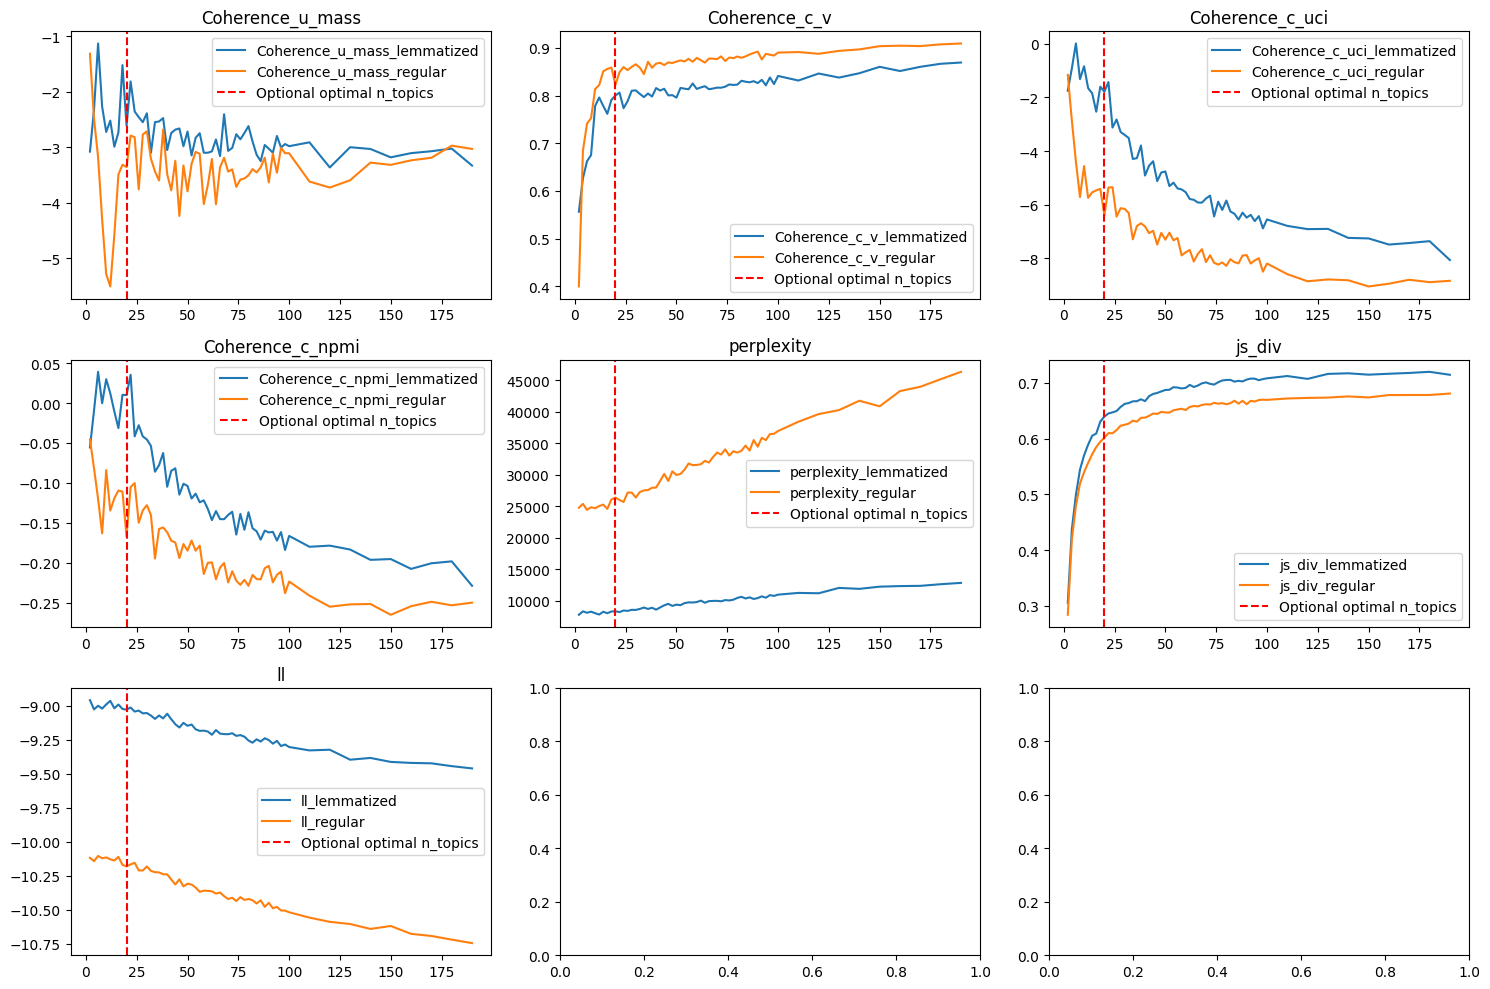

In [6]:
tp_comparison = tp_simulation_results_lem.join(tp_simulation_results, lsuffix="_lemmatized", rsuffix="_regular")

metrics = tp_simulation_results_lem.columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # Adjust the figure size as necessary
axes = axes.flatten()
# Loop through the metrics and plot
for i, metric in enumerate(metrics):
    # Topic Modeling Toolbox comparison plots
    cols_tp = [f"{metric}_lemmatized", f"{metric}_regular"]
    axes[i].plot(tp_comparison.index, tp_comparison[cols_tp[0]], label=cols_tp[0])
    axes[i].plot(tp_comparison.index, tp_comparison[cols_tp[1]], label=cols_tp[1])
    axes[i].axvline(x=20, color='r', linestyle='--', label='Optional optimal n_topics')

    axes[i].set_title(f"{metric}")
    axes[i].legend()

# Adjust layout

plt.tight_layout()
plt.show()


The perplexity reaches its minimum value quite early, around 15 topics (the ll - loglikelihood as well). Various coherence measures suggest that the optimal number of topics lies between 15-25. However, according to other studies, the most reliable coherence metric is C_V, which converges to the optimal number of topics at approximately 15. The JS measure (Jensen–Shannon divergence) appears to stabilize after 25-50 topics, though it is primarily used as a sanity check.

The comparison between lemmatized and regular text is not relevant in terms of absolute numbers due to the difference in their vocabularies (25,000 unique words for regular text versus 12,000 for lemmatized text). The main objective was to observe whether their metrics behave differently as a function of the number of topics.

Many parameters can significantly influence the optimal number of topics, such as the initial parameters for the LDA model and the extent to which common words are removed. I came across the article [Is Automated Topic Model Evaluation Broken? The Incoherence of Coherence:
The Incoherence of Coherence](https://arxiv.org/pdf/2107.02173), which argues that current evaluation methods, like perplexity and coherence, are inadequate, and human evaluation remains the best measure. I have experimented with various numbers of topics to determine the optimal count.

#### Selecting number of topics with Hierarchical Dirichlet Processes

The Hierarchical Dirichlet Process (HDP) is an advanced Bayesian model that is particularly useful for problems where you need to infer the number of underlying groups or patterns in data without specifying the number in advance. It extends the Dirichlet Process (DP) by linking multiple DPs through a shared base distribution, allowing for a hierarchy of groups that can share statistical strength.

In the context of topic modeling, the HDP is advantageous because it can automatically determine the number of topics present in a collection of documents.

[Hierarchical Dirichlet process](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process)

In [7]:
import tomotopy as tp
from gensim.models import CoherenceModel


def plot_hdp_res(hdp_res):
    means = hdp_res.reset_index().groupby("num_topics")[['loglik', 'perplexity', 'coherence']].mean()
    stds = hdp_res.reset_index().groupby("num_topics")[['loglik', 'perplexity', 'coherence']].std().fillna(0)

    lower_bound = means - stds
    upper_bound = means + stds

    fig, ax1 = plt.subplots()

    # Plot for perplexity
    ax1.fill_between(means.index, lower_bound['perplexity'], upper_bound['perplexity'], alpha=.3)
    ax1.plot(means.index, means['perplexity'], label='Perplexity', color='b')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Perplexity', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.fill_between(means.index, lower_bound['coherence'], upper_bound['coherence'], alpha=.3, color='red')
    ax2.plot(means.index, means['coherence'], label='Coherence', color='red')
    ax2.set_ylabel('Coherence', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title("Score of Perplexity and Coherence")
    fig.tight_layout()  # Adjust layout to prevent overlap

    plt.show()


def train_evaluate_hdp(gamma, alpha, eta, texts, iter_range=range(0, 1000, 100)):
    term_weight = tp.TermWeight.ONE
    hdp = tp.HDPModel(tw=term_weight, gamma=gamma, alpha=alpha, eta=eta,
                      initial_k=2, seed=42)

    # Add docs to train
    for vec in texts:
        hdp.add_doc(vec)

    # Initiate sampling burn-in
    hdp.burn_in = 100
    hdp.train(0)
    hdp_results = []

    # Train model
    for i in iter_range:
        hdp.train(100, show_progress=False)  # 100 iterations at a time
        # topics_d = get_hdp_topics(hdp, top_n=10)
        coherence_score = tp.coherence.Coherence(hdp, coherence='c_v').get_score()
        hdp_results.append((i, hdp.ll_per_word, hdp.live_k, hdp.perplexity, coherence_score, gamma, alpha, eta))
        print(
            f"{datetime.now()}---{i=}, {hdp.ll_per_word=}, {hdp.live_k=}, {hdp.perplexity=}, {coherence_score=}, {gamma=}, {alpha=}, {eta=}")

    return hdp_results


In [8]:
if RERUN:
    gammas = [0.01, 0.1, 0.5, 0.99]
    alphas = [0.01, 0.1, 0.5, 0.99]
    etas = [0.005, 0.01, 0.1, 0.5, 0.99]

    # List to store all results
    all_results = []

    # Loop over all combinations of gamma, alpha, and eta
    for gamma in gammas:
        for alpha in alphas:
            for eta in etas:
                print(f'Training with gamma={gamma}, alpha={alpha}, eta={eta}')
                results = train_evaluate_hdp(gamma, alpha, eta, texts, range(0, 1000, 100))
                all_results.extend(results)

    # Create DataFrame with all results
    columns = ["iter", "loglik", "num_topics", "perplexity", "coherence", "gamma", "alpha", "eta"]
    hdp_res = pd.DataFrame(all_results, columns=columns)

    # Sort and set index
    hdp_res = hdp_res.sort_values(by="num_topics").set_index("num_topics")
    hdp_res.to_csv("data/hdp_hp_opt_v2.csv")


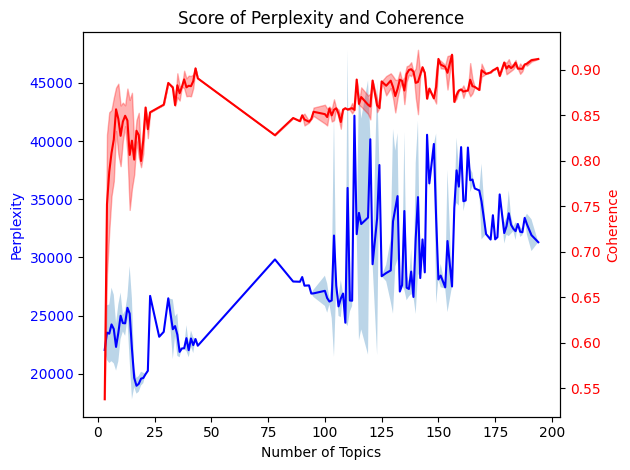

In [9]:
hdp_res = pd.read_csv("data/hdp_hp_opt_v2.csv")
plot_hdp_res(hdp_res)

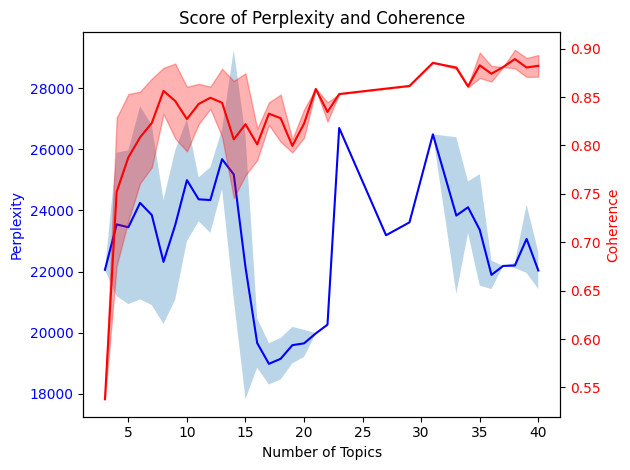

In [11]:
plot_hdp_res(hdp_res[hdp_res["num_topics"] <= 40])

Ive run the HDP model for different parameters, and those plots show the different number of topics that the model infer, with their corresponding metrics.
The best number of topics is around 15-20 for our dataset.

#### Hyper paramter tuning of the best number of topics

After trying different methods and different parameters, it seems like the best number of topics for our dataset is somewhere between 18-22.
I will train LDA model with different parameters to get the best model, and will use this model

In [12]:


def train_lda_tomotopy(corpus, k, alpha, eta, min_cf, min_df, tw, rm_top):
    results = []
    tmp_iter = {}
    model = tp.LDAModel(k=k, alpha=alpha, eta=eta, min_cf=min_cf, min_df=min_df, rm_top=rm_top, corpus=corpus, seed=42,
                        tw=tw)
    model.train(200)  # number of iterations, adjust as necessary
    perplexity = compute_perplexity(model)
    ch = tp.coherence.Coherence(model, coherence="c_v")
    tmp_iter.update(
        {"num_topics": k, "perplexity": perplexity, f"Coherence_c_v": ch.get_score(), "alpha": alpha, "eta": eta,
         "min_df": min_df, "tw": str(tw), "rm_top": rm_top, "min_cf": min_cf})
    print(f"{datetime.now()} - {tmp_iter}")
    return tmp_iter


texts_lem, id2word_lem, corpus_lem = generate_components("lemmatized_text", 42, 1, 4, 8, 10, False, False)
texts, id2word, corpus = generate_components("processed_text", 42, 1, 4, 8, 10, False, False)
corpus_tp = tp.utils.Corpus()
for text in texts:
    corpus_tp.add_doc(words=text)
corpus_tp_lem = tp.utils.Corpus()
for text in texts_lem:
    corpus_tp_lem.add_doc(words=text)



In [13]:
optional_topics = [18, 19, 20, 21, 22]
min_dfs = [1, 3, 5, 7]  #using only words that appeared in at least n documents
min_cfs = [2, 6, 10]  #using only words that appeared less than n times
rm_tops = [3, 7, 10]  #excluding the n most frequent words with
alphas = [0.01, 0.05, 0.1]
etas = [0.01, 0.05, 0.1]
tws = [tp.TermWeight.IDF, tp.TermWeight.ONE]

if RERUN:

    # List to store all results
    all_results = []

    # Loop over all combinations of gamma, alpha, and eta
    for k in optional_topics:
        for alpha in alphas:
            for eta in etas:
                for min_df in min_dfs:
                    for min_cf in min_cfs:
                        for tw in tws:
                            for rm_top in rm_tops:
                                # print(f'Training with alpha={alpha}, eta={eta}')
                                results = train_lda_tomotopy(corpus_tp, k, alpha, eta, min_cf, min_df, tw, rm_top)
                                all_results.append(results)

    # Create DataFrame with all results
    hyper_paramter_lda = pd.DataFrame(all_results)

    # Sort and set index
    hyper_paramter_lda = hyper_paramter_lda.sort_values(by="num_topics").set_index("num_topics")
    hyper_paramter_lda.to_csv("data/hyper_paramter_lda.csv")

if RERUN:

    # List to store all results
    all_results = []

    # Loop over all combinations of gamma, alpha, and eta
    for k in optional_topics:
        for alpha in alphas:
            for eta in etas:
                for min_df in min_dfs:
                    for min_cf in min_cfs:
                        for tw in tws:
                            for rm_top in rm_tops:
                                results = train_lda_tomotopy(corpus_tp_lem, k, alpha, eta, min_cf, min_df, tw, rm_top)
                                all_results.append(results)

    # Create DataFrame with all results
    hyper_paramter_lda = pd.DataFrame(all_results)

    # Sort and set index
    hyper_paramter_lda = hyper_paramter_lda.sort_values(by="num_topics").set_index("num_topics")
    hyper_paramter_lda.to_csv("data/hyper_paramter_lda_lem.csv")



In [14]:
#get the best models by coherence, and then by perplexity, and finding the best in common:
hyper_paramter_lda = pd.read_csv("data/hyper_paramter_lda.csv")
sorted_1 = hyper_paramter_lda.sort_values(by=["Coherence_c_v", "perplexity"], ascending=[False, True])
sorted_2 = hyper_paramter_lda.sort_values(by=["Coherence_c_v", "perplexity"], ascending=[True, False])

# Find common rows
common_rows = pd.merge(sorted_1, sorted_2,
                       on=["num_topics", "perplexity", "Coherence_c_v", "alpha", "eta", "min_df", "tw", "rm_top",
                           "min_cf"])
best_params = common_rows.reset_index().iloc[0, :].to_dict()
common_rows.iloc[:5, :]


,num_topics,perplexity,Coherence_c_v,alpha,eta,min_df,tw,rm_top,min_cf
0,18,689.692810,0.878611,0.10,0.05,1,TermWeight.IDF,7,10
1,18,686.992801,0.877342,0.01,0.10,1,TermWeight.IDF,7,10
2,21,1048.088249,0.874229,0.01,0.05,1,TermWeight.IDF,7,6
3,21,657.411941,0.873464,0.10,0.10,1,TermWeight.IDF,7,10
4,18,687.764846,0.872977,0.05,0.05,1,TermWeight.IDF,3,10


In [15]:
#get the best models by coherence, and then by perplexity, and finding the best in common:
hyper_paramter_lda = pd.read_csv("data/hyper_paramter_lda_lem.csv")
sorted_1 = hyper_paramter_lda.sort_values(by=["Coherence_c_v", "perplexity"], ascending=[False, True])
sorted_2 = hyper_paramter_lda.sort_values(by=["Coherence_c_v", "perplexity"], ascending=[True, False])

# Find common rows
common_rows = pd.merge(sorted_1, sorted_2,
                       on=["num_topics", "perplexity", "Coherence_c_v", "alpha", "eta", "min_df", "tw", "rm_top",
                           "min_cf"])
best_params_lem = common_rows.reset_index().iloc[0, :].to_dict()
common_rows.iloc[:5, :]


,num_topics,perplexity,Coherence_c_v,alpha,eta,min_df,tw,rm_top,min_cf
0,19,803.086912,0.837568,0.05,0.01,1,TermWeight.IDF,10,10
1,22,1642.186023,0.837107,0.05,0.05,1,TermWeight.IDF,10,2
2,20,966.446260,0.835801,0.05,0.10,1,TermWeight.IDF,10,6
3,20,986.331584,0.834981,0.01,0.05,1,TermWeight.IDF,3,6
4,20,989.465067,0.834374,0.10,0.10,1,TermWeight.IDF,3,6


### Selected topic model analysis

The TermWeight.IDF is based on the following paper [Term Weighting Schemes for Latent Dirichlet Allocation](https://aclanthology.org/N10-1070.pdf)

In [16]:
texts_lem, id2word_lem, corpus_lem = generate_components("lemmatized_text", 42, 1, 4, 8, 10, words_removal=False,
                                                         bigram_process=False)
texts, id2word, corpus = generate_components("processed_text", 42, 1, 4, 8, 10, words_removal=False,
                                             bigram_process=False)
corpus_tp = tp.utils.Corpus()
for text in texts:
    corpus_tp.add_doc(words=text)
corpus_tp_lem = tp.utils.Corpus()
for text in texts_lem:
    corpus_tp_lem.add_doc(words=text)

In [17]:
def initialize_and_train_lda(params, corpus, term_weight=tp.TermWeight.IDF):
    model = tp.LDAModel(
        k=params["num_topics"],
        alpha=params["alpha"],
        eta=params["eta"],
        tw=term_weight,
        rm_top=params["rm_top"],
        min_cf=params["min_cf"],
        min_df=params["min_df"],
        corpus=corpus,
        seed=42
    )
    model.train(200)
    return model


# Train models with extracted parameters
model_tp = initialize_and_train_lda(best_params, corpus_tp)
model_tp_lem = initialize_and_train_lda(best_params_lem, corpus_tp_lem)



/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_33215/285734166.py:13: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(200)


### Selected topic model analysis

In [19]:
import pandas as pd


def generate_dominant_topic_df(model, corpus, is_tomotopy=False):
    df_topic_sents_keywords = pd.DataFrame()

    if is_tomotopy:
        for i, doc in enumerate(model.docs):
            topic_dist, _ = model.infer(doc)
            topic_num = topic_dist.argmax()
            prop_topic = topic_dist[topic_num]
            topic_keywords = ", ".join(word for word, _ in model.get_topic_words(topic_num))
            df_topic_sents_keywords = pd.concat(
                [df_topic_sents_keywords,
                 pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                              columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])],
                ignore_index=True)
    else:
        for i, row_list in enumerate(model[corpus]):
            row = row_list[0] if model.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:
                    wp = model.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    df_topic_sents_keywords = pd.concat(
                        [df_topic_sents_keywords,
                         pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                      columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])],
                        ignore_index=True)
                else:
                    break

    contents = pd.Series([' '.join(doc) for doc in corpus])
    df_topic_sents_keywords = pd.concat([df_topic_sents_keywords, contents], axis=1)
    df_topic_sents_keywords.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']
    df_topic_sents_keywords["book"] = df_by_book.reset_index()["book"]

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'book']
    return df_dominant_topic


import re


def print_top_topics_by_percentage(model, df_dominant_topic, model_type, num_words=15):
    topics_by_freq = df_dominant_topic.groupby("Dominant_Topic")["Document_No"].count().sort_values(
        ascending=False).to_frame()
    topics_by_freq["freq"] = topics_by_freq["Document_No"] / topics_by_freq["Document_No"].sum()
    topics_by_freq.reset_index(inplace=True)
    sorted_topics = topics_by_freq.sort_values(by="freq", ascending=False)["Dominant_Topic"].to_list()

    if model_type == "gensim":
        topics = model.print_topics(num_topics=-1, num_words=num_words)  # Adjust num_words as needed
    if model_type == "tomotopy":
        topics = [model.get_topic_words(k_topic, top_n=num_words) for k_topic in range(model.k)]
    topics = [topics[int(i)] for i in sorted_topics]
    # Clean the topics to remove probabilities
    cleaned_topics = []
    if model_type == "gensim":
        for topic_no, topic in topics:
            # Using a regular expression to find words in quotes
            words = re.findall(r'"([^"]*)"', topic)
            cleaned_topics.append(', '.join(sorted(words)))
    if model_type == "tomotopy":
        for topic in topics:
            words = [w[0] for w in topic]
            cleaned_topics.append(', '.join(sorted(words)))

    print(f"{model_type} num_topics={model.k}, sorted by % from all docs")
    for i, topic in zip(sorted_topics, cleaned_topics):
        doc_n = topics_by_freq[(topics_by_freq["Dominant_Topic"] == i)]["Document_No"].values[0]
        doc_ratio = topics_by_freq[(topics_by_freq["Dominant_Topic"] == i)]["freq"].values[0]
        print(f"Topic {i} ({doc_n} docs, {doc_ratio:.2%} from all docs): {topic}")



In [20]:
df_dominant_topic_tp = generate_dominant_topic_df(model_tp, corpus_tp, is_tomotopy=True)
print("Regular text")
print_top_topics_by_percentage(model_tp, df_dominant_topic_tp, "tomotopy", num_words=15)

print("-------------------------------------------------------------------------------------")

df_dominant_topic_tp_lem = generate_dominant_topic_df(model_tp_lem, corpus_tp_lem, is_tomotopy=True)
print("Lemmatized text")
print_top_topics_by_percentage(model_tp_lem, df_dominant_topic_tp_lem, "tomotopy", num_words=15)

Regular text
tomotopy num_topics=18, sorted by % from all docs
Topic 3 (97 docs, 25.33% from all docs): אמן, בם, בר, וא, וב, וי, ול, ום, ות, ים, כה, לם, שר, תה, תו
Topic 13 (49 docs, 12.79% from all docs): אלן, אנה, אנון, ארעא, דן, וחזית, כדי, להון, לכון, מלכא, מנהון, ענא, רבא, שמיא, שנין
Topic 12 (45 docs, 11.75% from all docs): אמת, אנשי, ביחד, בכול, בלוא, ואז, ואתה, ולוא, יחד, לכה, לכול, משפט, נהיה, עולם, צדק
Topic 0 (29 docs, 7.57% from all docs): אלוהיכה, ביום, בן, בני, האלה, הארץ, וביום, ויואמר, ויחנו, לאמור, להמה, לכמה, מאות, מושה, מצרים
Topic 15 (28 docs, 7.31% from all docs): אמר, דויד, הדבר, הימים, המה, העמים, הצדק, הרשע, ואשר, יהודה, כתוב, מורה, נוח, פשר, פשרו
Topic 1 (26 docs, 6.79% from all docs): אברהם, אלהי, אלוהים, השמים, וברוך, ויאמר, חסדו, יעקוב, לדויד, לעולם, ממני, נפשי, עשה, ציון, שמו
Topic 8 (24 docs, 6.27% from all docs): בשבת, דבר, היחד, הרבים, השבת, ואם, ואשר, וכול, וכן, ונענש, יום, ימים, רעהו, שלושים, שנה
Topic 10 (20 docs, 5.22% from all docs): אמר, בהם, ביד, 

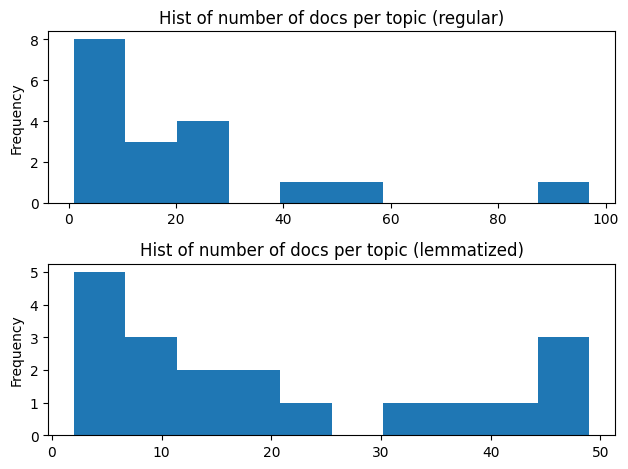

In [21]:
fig, ax = plt.subplots(2, 1)
df_dominant_topic_tp.groupby("Dominant_Topic")["Document_No"].count().plot(kind="hist",
                                                                           title="Hist of number of docs per topic (regular)",
                                                                           ax=ax[0])
df_dominant_topic_tp_lem.groupby("Dominant_Topic")["Document_No"].count().plot(kind="hist",
                                                                               title="Hist of number of docs per topic (lemmatized)",
                                                                               ax=ax[1])
plt.tight_layout()

My only concern about lemmatized text is that I don't know hoe good is the lemmatization model. I saw some words that he was not so successful in lemmatizing.
But we can see that topics seems better in the lemmatized text.

In [22]:
df_by_book = pd.read_csv('data/full_data_nonbib_01_05_24.csv')
df_by_book = pd.merge(df_dominant_topic_tp[["Dominant_Topic", "book"]], df_by_book, on="book")
df_by_book = pd.merge(
    df_dominant_topic_tp_lem[["Dominant_Topic", "book"]].rename(columns={"Dominant_Topic": "Dominant_Topic_lem"}),
    df_by_book, on="book")

In [40]:
from collections import Counter
import warnings
import matplotlib.colors as mcolors


def generate_word_dist_plot(model, texts, model_type, num_words_per_topic, biggest_topics, topics_to_show, title):
    warnings.filterwarnings("ignore")
    if model_type == "gensim":
        topics = model.show_topics(num_topics=-1, formatted=False, num_words=num_words_per_topic)
    if model_type == "tomotopy":
        topics = [model.get_topic_words(k_topic, top_n=num_words_per_topic) for k_topic in range(model_tp.k)]
        topics = enumerate(topics)
    data_flat = [w for w_list in texts for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(topics_to_show // 2, 2, figsize=(15, 10), sharey=True)
    cols = [color for name, color in mcolors.XKCD_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id == biggest_topics[i], :], color=cols[i],
               width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id == biggest_topics[i], :], color=cols[i],
                    width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(biggest_topics[i]), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels([w[::-1] for w in df.loc[df.topic_id == biggest_topics[i], 'word']], rotation=30,
                           horizontalalignment='right')  #reverse heb
        ax.tick_params(axis='x', labelrotation=45)
        ax.legend(loc='upper left');
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()
    warnings.filterwarnings("default")



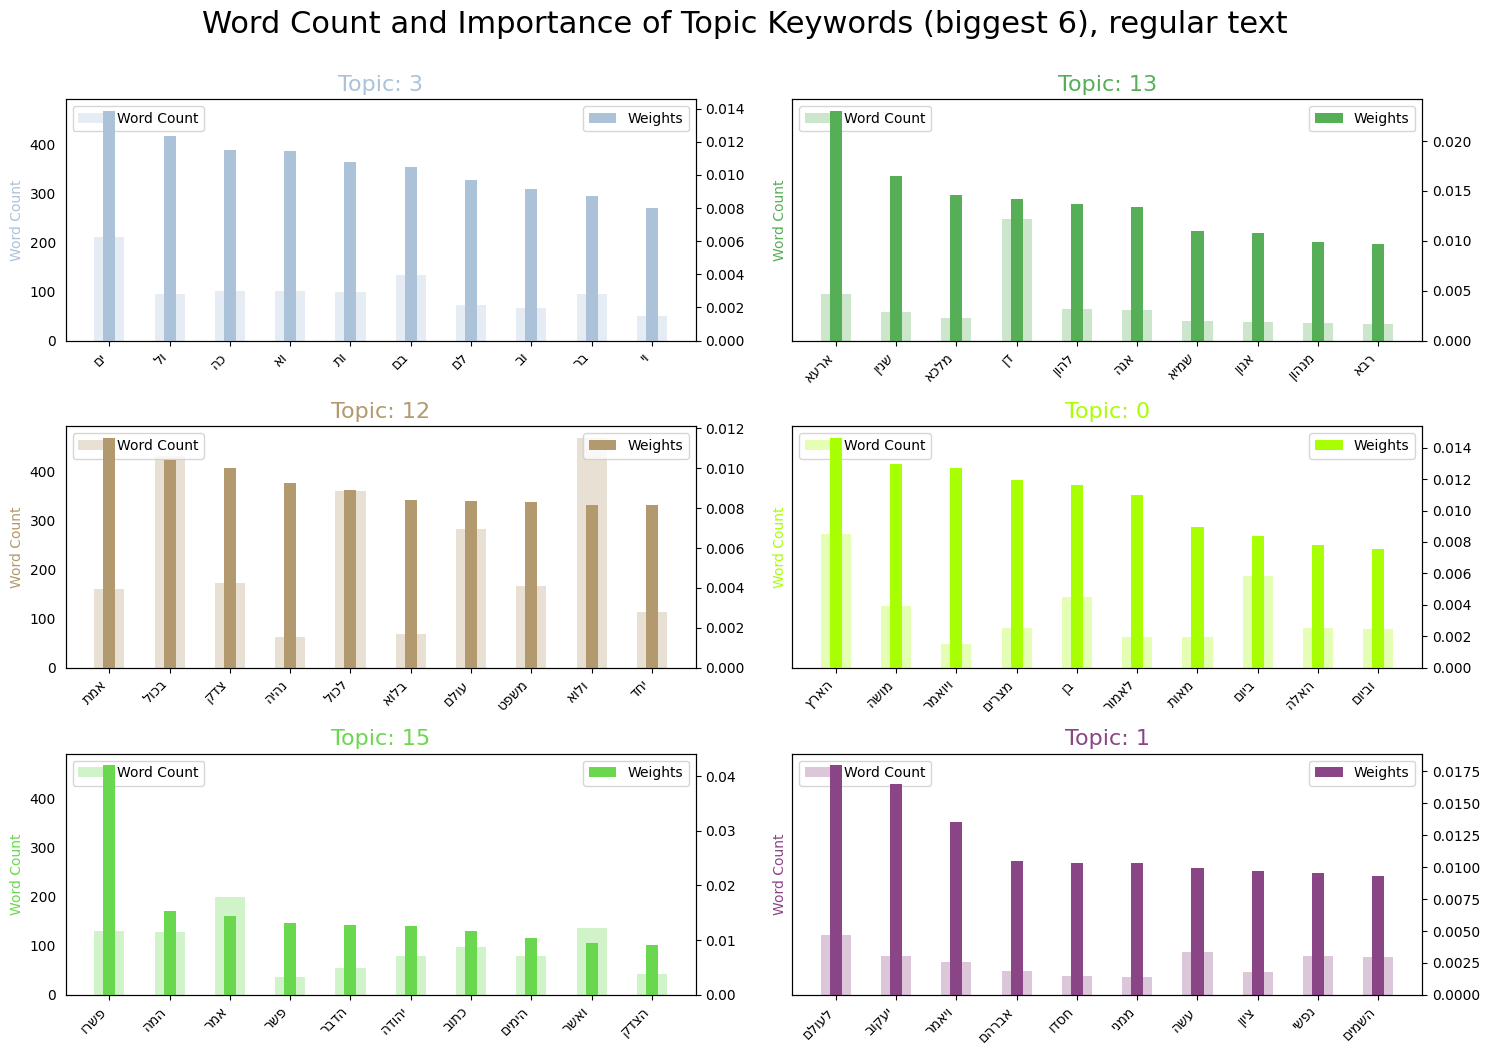

In [43]:
topics_to_show = 6
biggest_topics = df_dominant_topic_tp.groupby("Dominant_Topic")["Document_No"].count().sort_values(ascending=False)[
                 :topics_to_show].index.to_list()
generate_word_dist_plot(model_tp, texts, "tomotopy", 10, biggest_topics, topics_to_show,
                        f'Word Count and Importance of Topic Keywords (biggest {topics_to_show}), regular text')

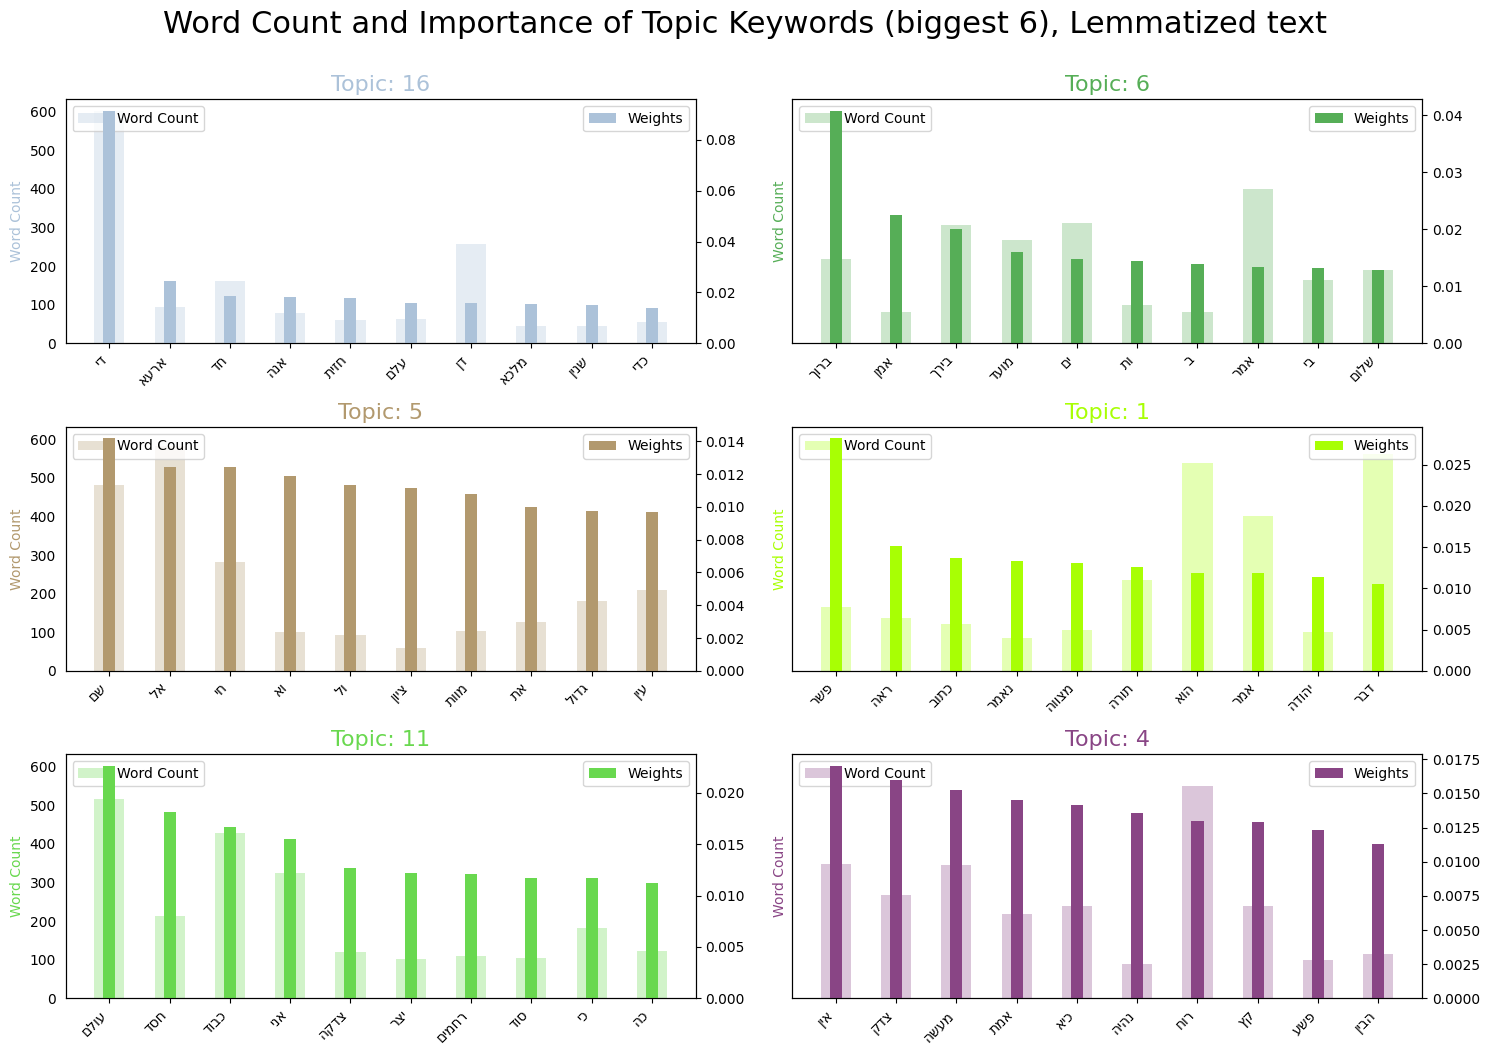

In [44]:
biggest_topics = df_dominant_topic_tp_lem.groupby("Dominant_Topic")["Document_No"].count().sort_values(ascending=False)[
                 :topics_to_show].index.to_list()
generate_word_dist_plot(model_tp_lem, texts_lem, "tomotopy", 10, biggest_topics, topics_to_show,
                        f'Word Count and Importance of Topic Keywords (biggest {topics_to_show}), Lemmatized text')

In [45]:
df_by_book.to_csv("data/full_data_nonbib_01_05_24_with_topics.csv", index=False)

### Appendinx - Type of coherence measures
Coherence measures in topic modeling are crucial for evaluating the quality of the topics extracted by models such as LDA. They help determine how meaningful and interpretable the topics are. I will give a short overview of four common types of coherence measures: `u_mass`, `c_v`, `c_uci`, and `c_npmi`, including their formulas and whether higher or lower values are better.

[Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324)

1. UCI is the first coherence measure developed by Newman et al. (2010). This measure calculates the coherence by using the top $N$ words from each topic. The UCI coherence is defined as follows:

$$
\text{UCI} = \frac{2}{N \cdot (N-1)} \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} \text{PMI}(w_i, w_j)
$$

Where:
- $N$ is the number of top words chosen for each topic.
- PMI($w_i, w_j$) represents the pointwise mutual information between words $ w_i $ and $ w_j $, calculated as:
  $$
  \text{PMI}(w_i, w_j) = \log \frac{P(w_i, w_j) + \epsilon}{P(w_i) \cdot P(w_j)}
  $$

- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring within a certain sliding window through the corpus.
- $ P(w_i) $ and $ P(w_j) $ are the probabilities of observing each word independently as the window slides through the corpus.
- $ \epsilon $ is a smoothing factor added to avoid taking a logarithm of zero. The original UCI measure sets $ \epsilon = 1 $.

UCI is essentially the average PMI of the top $ N $ words in each topic. As words co-occur more frequently within the specified context window, their PMI, and thus the UCI score, increases. This measure evaluates how semantically coherent the top words in a topic are, based on their co-occurrence in an external corpus.


2. UMass, developed by Mimno et al. (2011), computes the co-occurrence between pairs of words using only the model's training documents, unlike UCI which uses an external corpus. The UMass coherence measure is defined as follows:

$$
\text{UMass} = \frac{2}{N \cdot (N-1)} \sum_{i=1}^{N} \sum_{j=1}^{i-1} \log \frac{P(w_i, w_j) + \epsilon}{P(w_j)}
$$

Where:
- $ N $ is the number of top words selected from each topic.
- $ P(w_j) $ is the probability of observing word $ w_j $, calculated by counting how many documents contain the word $ w_j $.
- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring in the same documents, based on the count of documents that contain both words.
- $ \epsilon $ is a smoothing factor added to avoid taking a logarithm of zero, typically set to 1 in the original formulation.

While the formulas for UCI and UMass might look similar, their calculations differ significantly. UMass specifically looks for co-occurrence within the documents of the training corpus, focusing on document co-occurrence rather than sliding window co-occurrence. This measure calculates the average logarithmic document co-occurrence for each topic, and an increase in co-occurrence leads to a higher UMass score.

3. NPMI (Normalized Pointwise Mutual Information), introduced by Aletras and Stevenson (2013), modifies the traditional PMI (Pointwise Mutual Information) used in coherence measures like UCI by normalizing it. The normalization of PMI helps rescale the probabilities of word co-occurrence, which is defined as follows:

$$
\text{NPMI}(w_i, w_j) = \frac{\log \frac{P(w_i, w_j) + \epsilon}{P(w_i) \cdot P(w_j)}}{-\log (P(w_i, w_j) + \epsilon)}
$$

Where:
- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring within a specified context.
- $ P(w_i) $ and $ P(w_j) $ are the probabilities of observing each word independently.
- $ \epsilon $ is a smoothing factor, typically added to ensure the logarithm is not computed for zero.

This measure applies a negative logarithm to the co-occurrence probability of each word pair to normalize the results, making NPMI a ratio that ranges from -1 to 1. Studies such as those by Aletras and Stevenson (2013) and later by Lau et al. (2014) found that NPMI performed better and correlated more closely with human judgment compared to UCI. In practice, NPMI scores for all top word pairs in a topic are averaged to produce the final coherence score for that topic.

4. C_V Coherence Measure

Developed by Röder et al. (2015), the C_V coherence measure emerges from a comprehensive framework designed to enhance coherence calculations. This framework led to the development of several new coherence measures, with C_V being particularly noteworthy for its high correlation with human evaluations.

Unlike traditional coherence measures that rely on co-occurrence frequencies, C_V uses context vectors. These vectors count the occurrences of words within a window of ± five tokens from each top word but restricts this count to the topic's top words. This ensures that all vectors are uniform in length and composition.

For instance, if the top words in a topic are "game, sport, team," the context vector for "game" would be computed as follows:
$$
\vec{v}_{\text{game}} = [\text{NPMI}(\text{game, game}), \text{NPMI}(\text{game, sport}), \text{NPMI}(\text{game, team})]
$$

After constructing the context vectors, C_V computes the cosine similarity between them to gauge coherence:
$$
\text{cos}(\vec{u}, \vec{w}) = \frac{\sum_{i=1}^{|W|} u_i \cdot w_i}{\|\vec{u}\|^2 \cdot \|\vec{w}\|^2}
$$
where $ \vec{u} $ and $ \vec{w} $ are the context vectors being compared, and $ W $ represents all top word context vectors.

The key innovation of C_V is its focus on indirect semantic similarities rather than direct co-occurrences, allowing it to capture semantic relationships that are not evident through simple co-occurrence.


In the article [Exploring the Space of Topic Coherence Measures](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) the researchers showed that the CV method is mostly correlated with human judgments.




<!---
mostly taken from https://fse.studenttheses.ub.rug.nl/28618/1/s2863685_alfiuddin_hadiat_CCS_thesis.pdf
-->